# Doing #science with WRF

### Introduction

In the last exercise, we learned how to read in WRF data, and how make some basic visualizations (time series, vertical cross sections).  Now, let's actually do some science.

For this exercise we will compare two WRF runs quantitatively.  In this exercise, I will use the default run that we set up last week as a control run.  It has 250 m grid spacing in all directions.  The science question that we will address is: "What impact does higher resolution have on simulating the convection?"  Do address this question, we will run a simulation varied resolution to see what the impacts are.  What are some hypotheses that you might test with this sort of experiment?

This [paper](http://journals.ametsoc.org/doi/abs/10.1175/1520-0493%282003%29131%3C2394%3ARRFTSO%3E2.0.CO%3B2) can be used as a guide.

I made some modifications to the namelist to accomplish this higher resolution run.  See

`/oasis/scratch/snesbitt/temp_project/WRFV3/test/em_squall2d_x_100m`

For next class, I would like you to prepare simulations at 10 km, 4 km, 1 km, 250 m (control), and 100 m *horizontal* and *vertical* grid spacing.  Keep all other physical parameterizations and timing the same.  You will have to scale the timestep from a base of 2 s at 250 m.  You will have to use the fractional time step control to perform this scaling.

Take a look at the initialization code to make sure that the initial conditions work across resolutions.  The fortran code is here:

`WRFV3/dyn_em/module_initialize_squall2d_x.F`

---

### Plot some comparisons

In [1]:
%pylab inline
import xarray as xr

dataset_ctl = xr.open_dataset("/oasis/scratch/snesbitt/temp_project/WRFV3/test/em_q_250m/wrfout_d01_0001-01-01_00:00:00")


Populating the interactive namespace from numpy and matplotlib


Let's take a look at the 100 m output:

In [2]:
print(dataset_ctl)

<xarray.Dataset>
Dimensions:                (Time: 25, bottom_top: 80, bottom_top_stag: 81, soil_layers_stag: 5, south_north: 503, south_north_stag: 504, west_east: 503, west_east_stag: 504)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 0.0 0.0 ...
    XLONG                  (Time, south_north, west_east) float32 0.0 0.0 ...
    XTIME                  (Time) datetime64[ns] 2001-01-01 ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 0.0 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 0.0 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 0.0 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 0.0 ...
  * Time                   (Time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * bottom_top             (bottom_top) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 ...
  * bottom_top_stag        (bottom_top_stag) int64 0 1 2 3 4 5 6 7 8 9 10 11 ...
  * soil_layers_stag 

Let's get the total rain for each dataset:

In [3]:
total_rain_ctl = (dataset_ctl['RAINNC'].sum(dim=['south_north'], keep_attrs=True).sum(dim=['west_east'], keep_attrs=True))


Plotting comparisons like this is very straightforward.

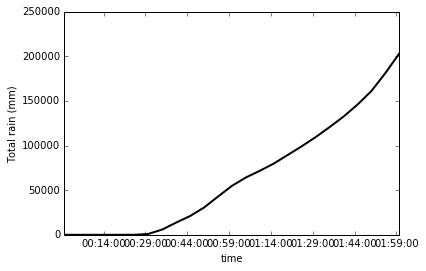

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)

lines = ax.plot(total_rain_ctl.XTIME,total_rain_ctl, color='k', lw=2)
ax.set_xlabel('time')
ax.set_ylabel("Total rain ({})".format(total_rain_ctl.units))

It's raining more in the high resolution dataset, but there are more grid points to sum over.  We can normalize the values by dividing by the number of points in the `west_east` dimension.

In [5]:
#get sizes of arrays
sz_ctl=np.shape(dataset_ctl['RAINNC'])
print(sz_ctl)


(25, 503, 503)


OK, let's use the float of the correct dimension to "normalize" for the grid dimension.

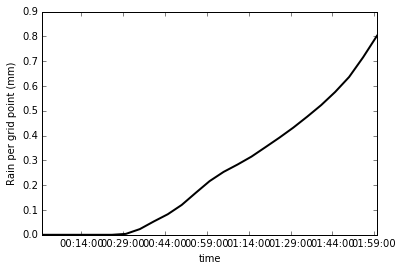

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

lines = ax.plot(total_rain_ctl.XTIME,total_rain_ctl/float(sz_ctl[1]*sz_ctl[2]), color='k', lw=2)
ax.set_xlabel('time')
ax.set_ylabel("Rain per grid point ({})".format(total_rain_ctl.units))

Now let's look at the statistics of vertical velocity.

In [7]:
w_ctl=dataset_ctl['W']
sz=np.shape(w_ctl)
print(sz)

(25, 81, 503, 503)


[  0.           2.76917624   8.90693855  27.18152237  57.24087143
  61.0506134   51.78809357  47.387146    46.06273651  48.96796417
  45.68093491  43.6304512   42.95640564  33.41207504  52.99006653
  38.47160721  31.63401031  47.37299728  50.8098259   35.35826874
  52.51102066  49.71798706  50.60784912  55.15204239  53.99787903]


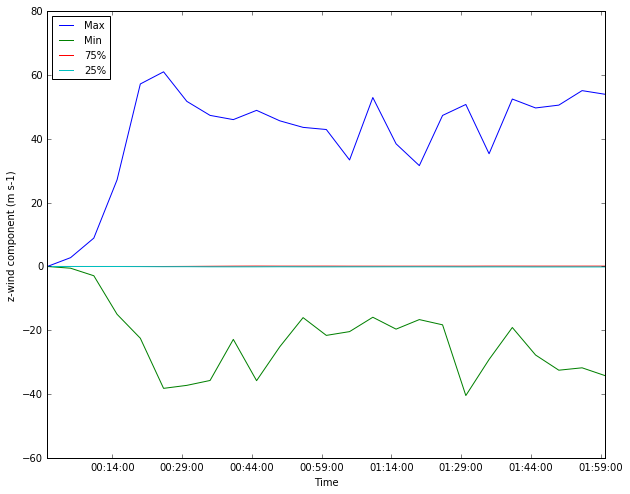

In [8]:
#allocate array
w_max_t=np.zeros(sz[0])
w_min_t=np.zeros_like(w_max_t)
w_pct75_t=np.zeros_like(w_max_t)
w_pct25_t=np.zeros_like(w_max_t)

#loop over elements
for t in np.arange(sz[0]):
    w_max_t[t]=np.max(w_ctl[t,:,:])
    w_min_t[t]=np.min(w_ctl[t,:,:])
    w_pct75_t[t]=np.percentile(w_ctl[t,:,:],75.)
    w_pct25_t[t]=np.percentile(w_ctl[t,:,:],25.)
    
print(w_max_t)
plt.figure(figsize=(10,8))
plt.plot(w_ctl.XTIME,w_max_t)
plt.plot(w_ctl.XTIME,w_min_t)
plt.plot(w_ctl.XTIME,w_pct75_t)
plt.plot(w_ctl.XTIME,w_pct25_t)

plt.xlabel('Time')

plt.ylabel('{0} ({1})'.format(w_ctl.description,w_ctl.units))
plt.legend(['Max','Min','75%','25%'],loc='upper left',prop={'size':10})

Now let's contour some extreme values as a function of height and time.

In [9]:
plt.figure(figsize=(11,8.5))
plt.contourf(w_ctl.XTIME.values,np.arange(0.,20.25,.25),np.amax(w_ctl.values,axis=2).transpose(),levels=np.arange(0,43.,5))
plt.colorbar()
plt.contour(w_ctl.XTIME.values,np.arange(0.,20.25,.25),np.amin(w_ctl.values,axis=2).transpose(),levels=[-10,-5,-1])


MemoryError: 

In [ ]:
plt.figure(figsize=(11,8.5))
plt.pcolormesh(w_ctl.XTIME.values,np.arange(0.,20.25,.25),np.amax(w_ctl.values,axis=2).transpose())
plt.colorbar()

In [ ]:
hydro_ctl=(dataset_ctl['QRAIN']+dataset_ctl['QGRAUP']+dataset_ctl['QSNOW']).mean(dim=['south_north'], keep_attrs=True)
print(np.shape(hydro_ctl))
plt.figure(figsize=(11,8.5))
plt.contourf(hydro_ctl.XTIME.values,np.arange(0.,20.,.25),np.amax(hydro_ctl.values,axis=2).transpose())
plt.colorbar()
